In [1]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.1 MB/s eta 0:00:00


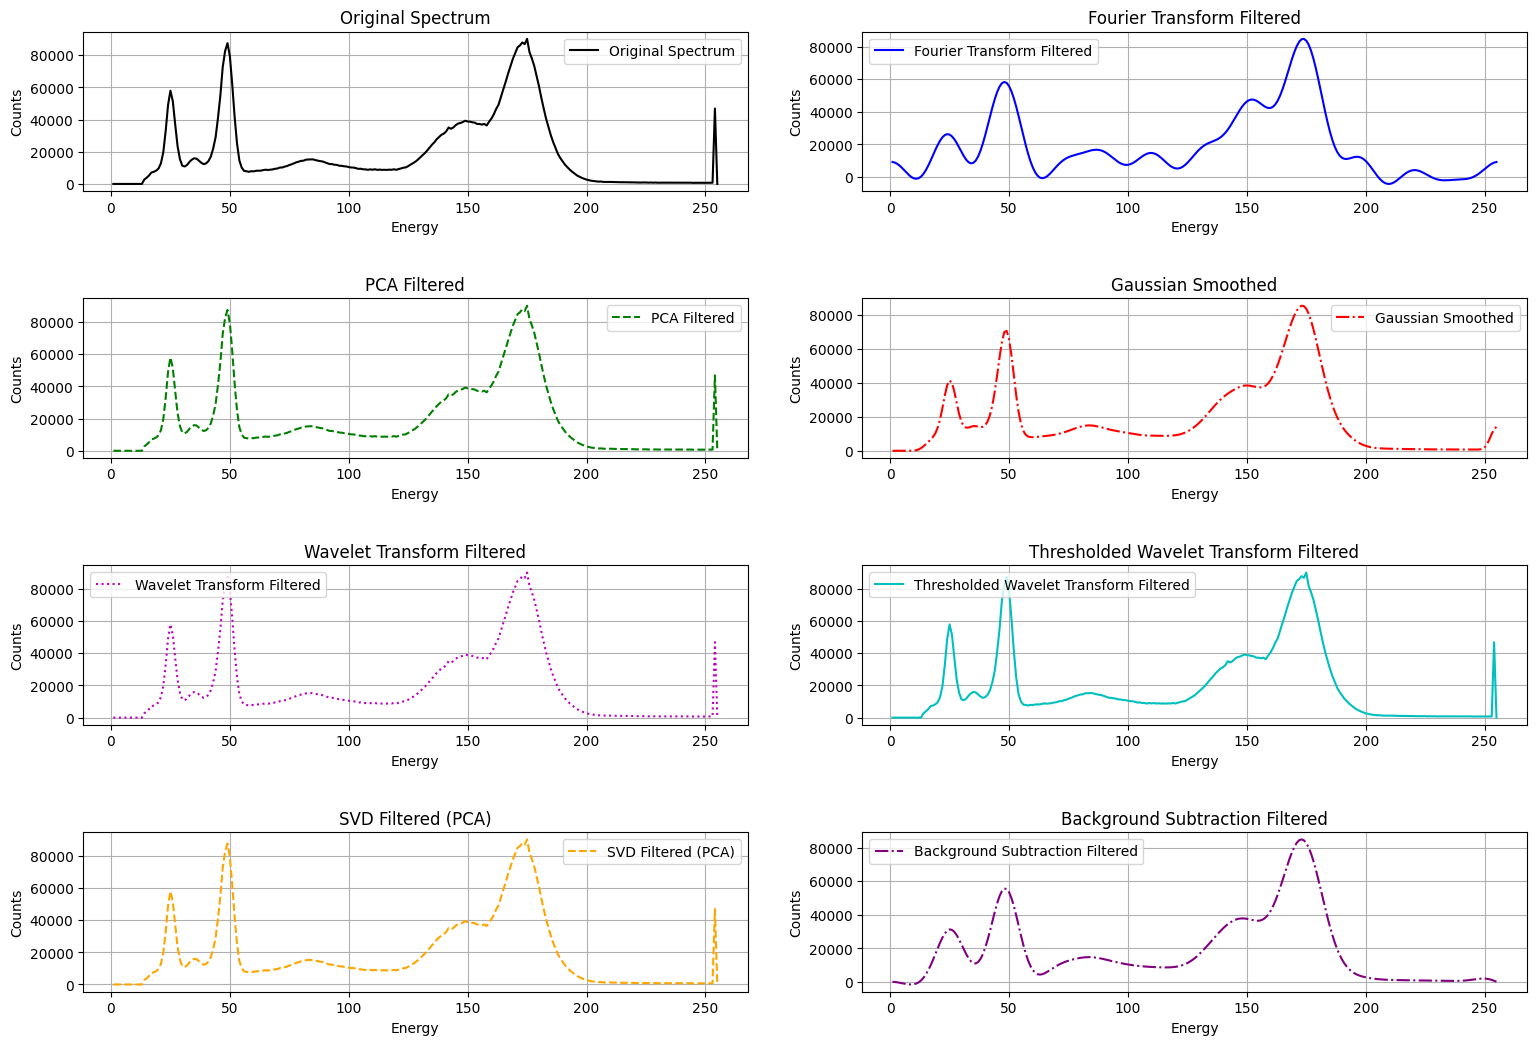

In [5]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from sklearn.decomposition import PCA
import pywt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# 1. Read data from the CSV file
filename = '15.5.csv'
data = pd.read_csv(filename)

# Assuming the columns are named 'energy' and 'counts' in your CSV
energy = data.iloc[:, 0].values
spectrum = data.iloc[:, 1].values  # 'counts' as the intensity

# Helper function to ensure lengths match
def ensure_length(original, processed):
    if len(processed) != len(original):
        # Truncate or pad to match original length
        processed = processed[:len(original)]
    return processed

# 2. Apply Fourier Transform
spectrum_fft = fft(spectrum)
threshold_fft = 0.1 * np.max(np.abs(spectrum_fft))
spectrum_fft[np.abs(spectrum_fft) < threshold_fft] = 0
spectrum_filtered_fft = np.real(ifft(spectrum_fft))
spectrum_filtered_fft = ensure_length(spectrum, spectrum_filtered_fft)

# 3. Apply Principal Component Analysis (PCA)
spectrum_pca = spectrum.reshape(-1, 1)
pca = PCA(n_components=1)
spectrum_pca_reduced = pca.fit_transform(spectrum_pca)
spectrum_filtered_pca = pca.inverse_transform(spectrum_pca_reduced).flatten()

# 4. Apply Two-Stage Smoothing Based on Impulse Deviation Correction (MBC)
spectrum_smoothed = gaussian_filter1d(spectrum, sigma=2)
spectrum_smoothed = ensure_length(spectrum, spectrum_smoothed)

# 5. Apply Shift-Invariant Wavelet Transform
coeffs = pywt.wavedec(spectrum, 'db1', level=4)
threshold_wavelet = 0.2
coeffs_thresholded = [pywt.threshold(c, threshold_wavelet, mode='soft') for c in coeffs]
spectrum_filtered_wavelet = pywt.waverec(coeffs_thresholded, 'db1')
spectrum_filtered_wavelet = ensure_length(spectrum, spectrum_filtered_wavelet)

# 6. Apply Thresholded Wavelet Transform
coeffs = pywt.wavedec(spectrum, 'db1', level=4)
coeffs_thresholded = [pywt.threshold(c, threshold_wavelet, mode='soft') for c in coeffs]
spectrum_filtered_wavelet_threshold = pywt.waverec(coeffs_thresholded, 'db1')
spectrum_filtered_wavelet_threshold = ensure_length(spectrum, spectrum_filtered_wavelet_threshold)

# 7. Apply Normalized Adjusted Singular Value Decomposition (NASVD)
# Using PCA as a substitute for NASVD in this context
spectrum_matrix = spectrum.reshape(-1, 1)
pca = PCA(n_components=1)
spectrum_svd_reduced = pca.fit_transform(spectrum_matrix)
spectrum_filtered_svd = pca.inverse_transform(spectrum_svd_reduced).flatten()

# 8. Apply Background Subtraction Methods
# Background subtraction using a low-pass Butterworth filter
b, a = butter(N=3, Wn=0.1, btype='low')
spectrum_filtered_background = filtfilt(b, a, spectrum)
spectrum_filtered_background = ensure_length(spectrum, spectrum_filtered_background)

# 9. Plot the results with two plots per row
plt.figure(figsize=(16, 24))

# Original Spectrum
plt.subplot(9, 2, 1)
plt.plot(energy, spectrum, 'k-', label='Original Spectrum', linewidth=1.5)
plt.title('Original Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# Fourier Transform Filtered
plt.subplot(9, 2, 2)
plt.plot(energy, spectrum_filtered_fft, color='b', linestyle='-', label='Fourier Transform Filtered', linewidth=1.5)
plt.title('Fourier Transform Filtered')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# PCA Filtered
plt.subplot(9, 2, 3)
plt.plot(energy, spectrum_filtered_pca, color='g', linestyle='--', label='PCA Filtered', linewidth=1.5)
plt.title('PCA Filtered')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# Gaussian Smoothed
plt.subplot(9, 2, 4)
plt.plot(energy, spectrum_smoothed, color='r', linestyle='-.', label='Gaussian Smoothed', linewidth=1.5)
plt.title('Gaussian Smoothed')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# Wavelet Transform Filtered
plt.subplot(9, 2, 5)
plt.plot(energy, spectrum_filtered_wavelet, color='m', linestyle=':', label='Wavelet Transform Filtered', linewidth=1.5)
plt.title('Wavelet Transform Filtered')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# Thresholded Wavelet Transform Filtered
plt.subplot(9, 2, 6)
plt.plot(energy, spectrum_filtered_wavelet_threshold, color='c', linestyle='-', label='Thresholded Wavelet Transform Filtered', linewidth=1.5)
plt.title('Thresholded Wavelet Transform Filtered')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# SVD Filtered (PCA)
plt.subplot(9, 2, 7)
plt.plot(energy, spectrum_filtered_svd, color='orange', linestyle='--', label='SVD Filtered (PCA)', linewidth=1.5)
plt.title('SVD Filtered (PCA)')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# Background Subtraction Filtered
plt.subplot(9, 2, 8)
plt.plot(energy, spectrum_filtered_background, color='purple', linestyle='-.', label='Background Subtraction Filtered', linewidth=1.5)
plt.title('Background Subtraction Filtered')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout(pad=3.0)
plt.show()
